#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '10BpRVGqYspXgLvgqmvTt09CR6zoW0PgY',
    # 'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    # 'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test': '19zceSKoNTFSdX0Ns5iEwsVNvtQ0kNXiN',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        # url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        url = f'https://drive.google.com/uc?id={DATASETS_LINKS[name]}'
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [6]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score
import gdown
import matplotlib.pyplot as plt


class Model:
    def __init__(self, num_classes=9, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.history = {'train_loss': [], 'f1_score': []}

    def save(self, name: str):
        save_path = f'/content/drive/MyDrive/cmcmsu/{name}.pth'
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    def load(self, name: str):
        name_to_id_dict = {
            'best': '1-2D_lHpfPKNXq0QdAgg-ZvTimw2UR-YZ',
            'model_epoch_1': '1z0C6YQrK049EAR5mnv3acs0k6LRfuPih',
            'model_epoch_2': '1-65NoMqyivAov0aafRP9yl0tmTJSyV0c',
            'model_epoch_3': '1-6DFHLiadalO337LJWrfW_pnyWBZu3wf',
            'model_epoch_4': '1-6WxGBGhm9RFjiWlCamQrOesYSegG2GZ',
            'model_epoch_5': '1-DbqihGv3XfwbI1Mu7STMiS3xhqlMjGS',
            'model_epoch_6': '1rHKzEj8IRRm9vySi9nxlSpMxcsBg6j-n',
            'model_epoch_7': '1-0N6OM5NI8VMxNL3UKAG-iHlNZkOZV0-',
            'model_epoch_8': '1-0Yxw-2WtfNxCIfTHtFlBd4Q_L6pwZwf',
            'model_epoch_9': '1-0eum_k74DMM51oMPUcZm8pzWojBXHsd',
            'model_epoch_10': '1-2D_lHpfPKNXq0QdAgg-ZvTimw2UR-YZ'
        }
        output = f'{name}.pth'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=True)
        self.model.load_state_dict(torch.load(output, map_location=self.device, weights_only=True))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {output}")

    def train(self, dataset, epochs=5, batch_size=32):
        self.model.train()
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        for epoch in range(epochs):
            running_loss = 0.0
            all_preds = []
            all_labels = []

            for _ in tqdm(range(dataset.n_files // batch_size)):
                imgs, labels = dataset.random_batch_with_labels(batch_size)
                imgs = torch.stack([train_transform(img) for img in imgs]).to(self.device)
                labels = torch.tensor(labels, dtype=torch.long).to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            avg_loss = running_loss / (dataset.n_files // batch_size)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            self.history['train_loss'].append(avg_loss)
            self.history['f1_score'].append(f1)

            #LBL5
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, F1 Score: {f1:.4f}")

            #LBL3
            self.save(f'model_epoch_{epoch + 1}')

        #LBL6
        self._plot_metrics()

    def test_on_dataset(self, dataset, batch_size=32, limit=None):
        self.model.eval()
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        with torch.no_grad():
            for imgs in tqdm(self._batched_images(dataset, n, batch_size), total=n // batch_size):
                imgs = torch.stack([transform(img) for img in imgs]).to(self.device)
                outputs = self.model(imgs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions

    def test_on_image(self, img: np.ndarray):
        self.model.eval()
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        img_tensor = transform(img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        return predicted.item()

    @staticmethod
    def _batched_images(dataset, n, batch_size):
        images = list(dataset.images_seq(n))
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size]

    def _plot_metrics(self):
        epochs = range(1, len(self.history['train_loss']) + 1)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Training Loss', color='blue')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['f1_score'], label='F1 Score', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('F1 Score')
        plt.legend()

        plt.show()


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [ ]:
d_train = Dataset('train')

Downloading...
From (original): https://drive.google.com/uc?id=10BpRVGqYspXgLvgqmvTt09CR6zoW0PgY
From (redirected): https://drive.google.com/uc?id=10BpRVGqYspXgLvgqmvTt09CR6zoW0PgY&confirm=t&uuid=0d60c2e0-5306-4785-9f11-5de10b09b533
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:31<00:00, 66.5MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


100%|██████████| 562/562 [03:09<00:00,  2.97it/s]


Epoch [1/10], Loss: 0.2483, F1 Score: 0.9352
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_1.pth


100%|██████████| 562/562 [03:14<00:00,  2.89it/s]


Epoch [2/10], Loss: 0.0498, F1 Score: 0.9849
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_2.pth


100%|██████████| 562/562 [03:14<00:00,  2.89it/s]


Epoch [3/10], Loss: 0.0302, F1 Score: 0.9909
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_3.pth


100%|██████████| 562/562 [03:14<00:00,  2.89it/s]


Epoch [4/10], Loss: 0.0246, F1 Score: 0.9929
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_4.pth


100%|██████████| 562/562 [03:13<00:00,  2.90it/s]


Epoch [5/10], Loss: 0.0186, F1 Score: 0.9947
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_5.pth


100%|██████████| 562/562 [03:14<00:00,  2.89it/s]


Epoch [6/10], Loss: 0.0178, F1 Score: 0.9943
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_6.pth


100%|██████████| 562/562 [03:13<00:00,  2.90it/s]


Epoch [7/10], Loss: 0.0116, F1 Score: 0.9965
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_7.pth


100%|██████████| 562/562 [03:13<00:00,  2.90it/s]


Epoch [8/10], Loss: 0.0128, F1 Score: 0.9964
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_8.pth


100%|██████████| 562/562 [03:14<00:00,  2.90it/s]


Epoch [9/10], Loss: 0.0110, F1 Score: 0.9966
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_9.pth


100%|██████████| 562/562 [03:14<00:00,  2.89it/s]


Epoch [10/10], Loss: 0.0123, F1 Score: 0.9962
Model saved to /content/drive/MyDrive/cmcmsu/model_epoch_10.pth


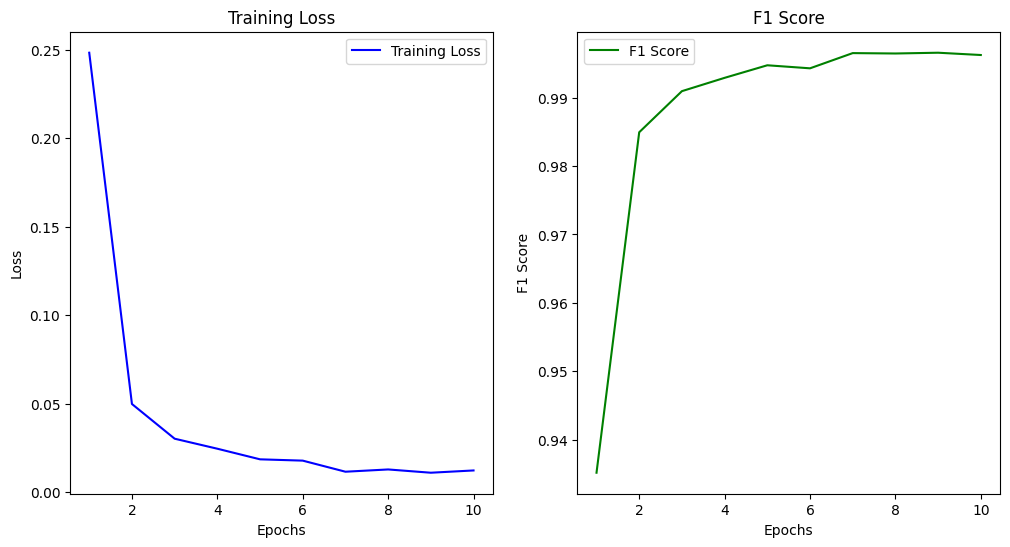

Model saved to /content/drive/MyDrive/cmcmsu/best.pth


In [ ]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train, epochs=10, batch_size=32)
    model.save('best')
else:
    model.load('best')

In [8]:
d_test = Dataset('test')

Downloading...
From (original): https://drive.google.com/uc?id=19zceSKoNTFSdX0Ns5iEwsVNvtQ0kNXiN
From (redirected): https://drive.google.com/uc?id=19zceSKoNTFSdX0Ns5iEwsVNvtQ0kNXiN&confirm=t&uuid=bbd0422d-e32c-4f14-924d-fa77d04a3f32
To: /content/test.npz
100%|██████████| 525M/525M [00:10<00:00, 52.1MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Начиная с одной из эпох модель могла начать переучиваться, а также получить bias в сторону равномерного распределения классов. Проверим, что с получившейся моделью такого не происходит. Для этого создадим небольшой датасет с неравномерным распределением классов из предоставленного тестового датасета и протестируем модель на нем.

In [9]:
class_ratios = {
    'ADI': 1,
    'BACK': 0.2,
    'DEB': 0.1,
    'LYM': 0.5,
    'MUC': 0.01,
    'MUS': 0.03,
    'NORM': 0.1,
    'STR': 0.02,
    'TUM': 0.03
}

def create_imbalanced_dataset(dataset, class_ratios, class_names):
    images = dataset.images
    labels = dataset.labels
    class_indices = {cls: i for i, cls in enumerate(class_names)}
    new_images = []
    new_labels = []

    for cls, ratio in class_ratios.items():
        class_index = class_indices[cls]
        cls_indices = np.where(labels == class_index)[0]
        n_samples = int(len(cls_indices) * ratio)
        selected_indices = np.random.choice(cls_indices, n_samples, replace=False)
        new_images.append(images[selected_indices])
        new_labels.append(labels[selected_indices])

    new_images = np.concatenate(new_images, axis=0)
    new_labels = np.concatenate(new_labels, axis=0)

    class ImbalancedDataset(Dataset):
        def __init__(self, images, labels):
            self.images = images
            self.labels = labels
            self.n_files = images.shape[0]
            self.is_loaded = True

    return ImbalancedDataset(new_images, new_labels)
imbalanced_test = create_imbalanced_dataset(d_test, class_ratios, TISSUE_CLASSES)

In [10]:
print(d_test.labels.shape)
print(imbalanced_test.labels.shape)

(4500,)
(995,)


In [12]:
imbalanced_test = create_imbalanced_dataset(d_test, class_ratios, TISSUE_CLASSES)
model = Model()
model.load('best')
pred = model.test_on_dataset(imbalanced_test)
Metrics.print_all(imbalanced_test.labels, pred, 'imbalanced test')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.8MB/s]


Model loaded from best.pth


32it [04:20,  8.15s/it]

metrics for imbalanced test:
	 accuracy 0.9970:
	 balanced accuracy 0.9951:


С моделью все в порядке. Протестируем ее на полном тестовом датасете.

In [13]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

141it [21:12,  9.02s/it]

metrics for test:
	 accuracy 0.9902:
	 balanced accuracy 0.9902:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [15]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Model loaded from best.pth


Downloading...
From: https://drive.google.com/uc?id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 53.8MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


3it [00:23,  7.71s/it]

metrics for test-tiny:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


Отмонтировать Google Drive.

In [16]:
drive.flush_and_unmount()